## Summary of the project

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/17 14:49:02 WARN Utils: Your hostname, dongmenghans-MacBook.local resolves to a loopback address: 127.0.0.1; using 10.13.133.28 instead (on interface en0)
22/10/17 14:49:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/17 14:49:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



<font color='#C6DEFF'><h2>1. Overview</h2></font> 


<font color='#98AFC7'><h3>Goal:</h3></font> 
The project is to built a ranking system for the merchants for BNPL company to partner up with.

<font color='#98AFC7'><h3>Metrics: </h3></font> 
1. Credibility - Whether the transaction is fraud

2. Predicted future Revenue 

3. Potential ability

4. Stability - monthly based variance

<font color='#C6DEFF'><h2>2. Preprocess</h2></font>

<font color='#98AFC7'><h3>External data set:</h3></font> 
Income and population information in different location divided by SA2 

Feature we used: SA2(for merging), total earners, median age, median income, population density

There were some missing values in the income table. We impute them by replacing it with the average value of its neighbors of the feature, as shown in this figure. 

<font color='#F0FFF0'> <b>A demonstrate photo: </b></font> 

<img src="../plots/annual_income.png" alt="Geospatial of annual income" style="width:330px;height:300px;">

<font color='#98AFC7'><h3>Primary data set:</h3></font> 
The information for merchants, consumers and transaction among them. \

Feature we used: merchant name, revenue level, take rate, category(preprocessed), gender, postcode, order time and dollor value

<font color='#FFE4B5'><h5>Category: </h5></font> 
The original dataset contain a feature called tag, it contains multiple features, such as revenue level and products for the transaction. \
\
We separated them into different features, and use the natural language process techniques to deal with the sentence that describes the product (therefore implies the category). \
\
The stop words such as and, is are removed, the product behind the word "except" are removed. \
In the end five categories are obtained. \
They are: "outdoor", "art and gifts", "music and books", "home and technology" and "fashion and accessories".

<br>

<font color='#FFE4B5'><h5>Postcode: </h5></font> 
<font color='#FFDAB9'><b>Issue: </b></font> 
There are pobox mixed with postcode, which caused difficulty in merging external datasets. \

<b>Solution</b> \
Use the <a href = https://auspost.com.au/postcode>website </a> to find the corresponding postcode for each pobox. \
Some of the po box are not valid since 2006, they were treated as noise and dropped

<font color='#98AFC7'><h3>Merging: </h3></font> 
<b>Join Key:</b> \
External: SA2 \
Internal: Postcode \
</br>

<font color='#FFDAB9'><b>Issue: </b></font> 
The SA2 and Postcode are two different unit for the location, they are not match. \
\
To achieve the most accurate match and lowest transaction lost, we overlayed the two keys one on top of the other to match their location. (shown in the graph, the red lines indicate postcode) \

\
Then the situation of more than one postcodes match one SA2 and vice versa. \
We use the weighted (percentage of area of one key in the other key) average to calculate the value  of the feature values.

<img src="../plots/overlay.png" alt="overlay map" style="width:330px;height:300px;">

The final table is shown as below

In [3]:
df = spark.read.parquet("../data/curated/merchant_consumer_abs")
df

22/10/17 14:49:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


postcode,total_earners,median_age,income_sum,2021_population,km2,income_mean,persons/km2,merchant_name,revenue_level,user_id,order_datetime,products,take_rate,tag,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender,fraud_group,__index_level_0__
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,10413,2022-04-27,artist supply and...,5.89,artist supply craft,art and gifts,375.16773164703153,2022,4,27,Kelly Clayton,4211 Rodney Tunne...,NT,0800,Female,0,0
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,22246,2022-10-07,artist supply and...,5.89,artist supply craft,art and gifts,617.8791313462011,2022,10,7,Corey Estrada,1703 Boyd Shore,NT,0800,Male,0,1
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,2681,2022-02-28,artist supply and...,5.89,artist supply craft,art and gifts,766.5077067424303,2022,2,28,Nicole Bishop,467 Robert Island...,NT,0800,Female,0,2
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Malesuada Vel Ltd,b,13454,2021-07-24,books periodicals...,3.56,books periodicals...,books and music,258.86595899218753,2021,7,24,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,3
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Varius Orci Insti...,a,10146,2021-08-08,tent and awning s...,6.3,tent awning,outdoors,4.159037931172075,2021,8,8,Shannon Mann,00817 Owens Circle,NT,0800,Female,0,4
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Volutpat Nulla In...,a,23093,2022-10-11,furniture home fu...,6.59,furniture home fu...,home and technology,8.26105405068297,2022,10,11,Robert Walker,646 Allison Ranch...,NT,0800,Male,0,5
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Mollis Integer Co...,b,13454,2022-05-02,digital goods boo...,3.96,digital goods boo...,books and music,83.63154755239155,2022,5,2,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,6
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,13454,2021-04-08,artist supply and...,5.89,artist supply craft,art and gifts,87.00495112586256,2021,4,8,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,7
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Eros Limited,c,8092,2021-12-18,digital goods boo...,2.52,digital goods boo...,books and music,8.26187754879106,2021,12,18,Rebecca Owens,92579 Keith Neck ...,NT,0800,Female,0,8
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Hendrerit A Corpo...,a,11203,2022-07-14,watch clock and j...,6.64,watch clock jewel...,fashion and acces...,100.80643267043831,2022,7,14,John Rodriguez,563 Wallace Rue,NT,0800,Male,0,9


<font color='#C6DEFF'><h2>3. Genetrate Ranking Criteria</h2></font>

<font color='#98AFC7'><h3>1. Credibility: </h3></font> 
<b>Motivation: </b>  \
We were given the fraud probability for each consumer with daily granularity, we want to utilize it as a ranking criteria. \
\
Moreover, there are many outliers, such as sudden jump in the dollar value of a particular day for one consumer. Instead of removing them, It is more useful to label them and includes in the ranking metric. \
\
The above two features were used to train a 3-mean clustering model. The result (as shown below) is very satisfiable,the two features are positively proportional to each other, the cluster with highest fraud probability also has the highest outlier rate. Then we labeled each group to high, median and low credibility to use as a factor for ranking system. 

<img src="../plots/fraud.png" alt="clustering result" style="width:330px;height:75px;">

Then we group by the merchant name and calculated the average of the fraud score for each transaction and standardized it to the value between 0 and 1.


<font color='#98AFC7'><h3>2. Revenue: </h3></font> 

The most important criteria for the ranking system is the revenue that can be generated for the BNPL company. Therefore, the future revenue based on the current datasets is predicted using gradient boost regression tree, in order to give an insight of future performance for each company.

We removed the outlier (and noise instances)before training, to minimise the disturbance for the model prediction. We grouped by revenue band and merchant name then summed up their revenue, any instances that after took away their mean is out of the 3 standard deviation, are considered as outliers. 

Then, we investigate the correlation with features, as shown below.

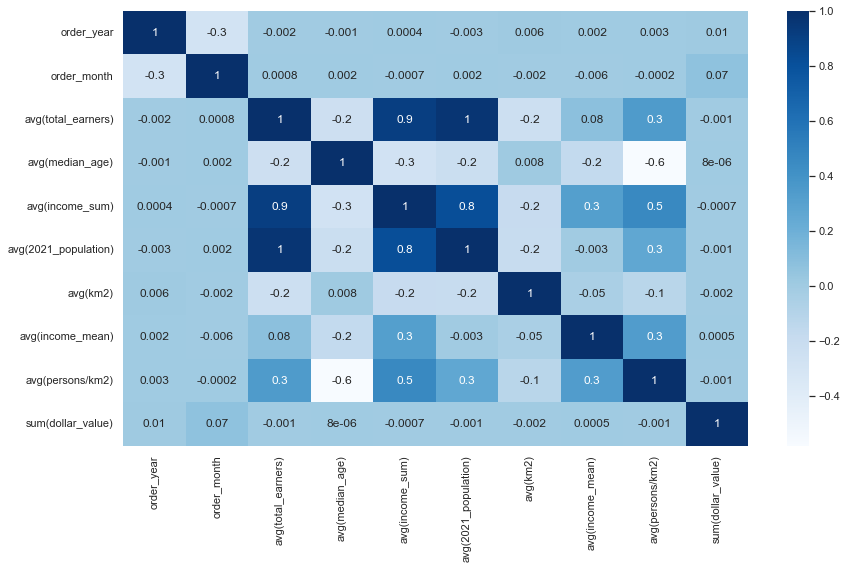

In [5]:
df_agg = df.groupBy(["merchant_name","order_year", "order_month"]).agg(mean("total_earners"),
                                                                    mean("median_age"), 
                                                                    mean("income_sum"),
                                                                    mean("2021_population"),
                                                                    mean("km2"),
                                                                    mean("income_mean"),
                                                                    mean("persons/km2"),
                                                                    sum("dollar_value"))
graph = df_agg.toPandas()
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = graph.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In term of the common sense, the feature "tag" (what a merchant is selling) will related to their "revenue_level" and also resulting in the different purchase peak ("order_month", "order_year"). Then we built interaction between those features. Also, we dropped some of the highly correlated external features.

We compared several different regression model, the best one is the gradient boosting tree.

The final R2 score for the model is: 0.765624

<img src="../plots/model_perform.png" alt="model performance" style="width:570px;height:200px;">

The below graph shows difference between the true and predict values for the first 40 instances, although there are over and under estimations for different part of revenue, they basically follow the same trend (rank) as the true value. 

The we use the percentage rank as the score for the revenue for each merchant. (e.g. top one is 100%)

<font color='#FFDAB9'><b>Limitation: </b></font> 
<li>There is not enough datasets, only two incomplete years are not enough for model to discover an accurate trend for each merchant. </li>

<li>The second one is to assume that there is no change in the trend in the future, that it will be the same as the current (known dataset) dataset, which is known as extrapolation.</li>



<font color='#98AFC7'><h3>3. Potential: </h3></font> 

The initial method is to use the gradient of the best fit line among the revenue, if the gradient is positive, then there is an overall increase, however, the gradient can be easily affected by the correlation between month and revenue. This is to the limitation that there is not enough datasets.

Then we compared if there is a increase in the monthly revenue between 2022 and 2021 for each merchant. The positive difference indicates the merchant has potential.

This method encountered the second limitation that the dataset for the two years is not completed, 2021 only contain the data from March to December and 2022 only contain the data from January to October, if the peak purchase period for a merchant is November and December, then this method will underestimate it's potential.

Then we scale the difference to the value between -1 and 1, and treated as a bonus mark for each merchants.

<font color='#E799A3'><b>Discovery: </b></font>
The purchase density for each merchant category is different, for example, the purchase density for "art and gifts" are relevently lower than "home and technology", but they make more revenue for each single transaction.



<font color='#98AFC7'><h3>4. Stability: </h3></font> 
We used the variance of monthly revenue of each merchant as the metric to measure the stability. 

The problem we encountered is that, some of the merchants only have one month has transactions, which means they will be very "stable", the variance is 0. 

To avoid this situation, we manually implemented the missing month with zero to increase the variance for these merchants.

Then we scale the stability to 0-1.

The final table with all the scores is shown as below

In [13]:
score = spark.read.parquet("../data/curated/score_table")
score

merchant_name,category,merchant_rev_score,category_rev_score,fraud_score,trend_score,variance_score
Malesuada Vel Ltd,books and music,0.6482306684141547,0.6735436893203883,0.9968982630272953,-0.2659155054587914,3.298045669878045E-4
Mollis Integer Co...,books and music,0.8681520314547837,0.8847087378640777,0.9988385598141696,-0.22634669382732775,0.003390957761643...
Volutpat Nulla In...,home and technology,0.9698558322411533,0.9711538461538461,0.9984037034080933,-0.24845221461810907,0.014523382876334779
Donec Luctus Indu...,fashion and acces...,0.6422018348623854,0.5954415954415955,0.9975812953507122,-0.2821378659840347,0.02459704997399887
Vulputate Velit E...,fashion and acces...,0.2566186107470511,0.2378917378917379,1.0,-0.28624214187783215,5.362807428715451...
Erat Semper Ltd,outdoors,0.9155963302752294,0.9036585365853659,0.9973759541984732,-0.2705380856818037,0.009104123221804636
Hendrerit Consect...,books and music,0.8125819134993447,0.8337378640776699,0.9981889105600446,-0.3230723102625034,0.001273636682038701
Vel Turpis Company,home and technology,0.46579292267365663,0.5021367521367521,0.9953416149068323,-0.3488128370442415,3.173017570266328...
Curabitur Vel LLC,books and music,0.3255570117955439,0.32402912621359226,1.0,-0.27967123028464425,2.463011880582002E-5
Malesuada PC,outdoors,0.4301441677588467,0.38414634146341464,0.997093023255814,-0.31026056064007324,1.459836605990655...


In [29]:
rank = spark.read.option("header", "true").csv("../data/result")

<font color='#C6DEFF'><h2>4. Rank and Result</h2></font>

We calculate the total score as follow: \
Score = ( Revenue × Credibility ) × 70% + Stability × 30% + Potential × 20%

<li>The most important one is the revenue * fraud score. The combination of those two gives an overall view of how much “valid” revenue a merchant could obtain in the coming 14 months. Therefore, a weight of 0.7 is assigned to it.</li>
<li>Then we assign 0.3 for the stability</li>
<li>Finally, we take the metric for a merchant’s potential as a bonus score with 0.2 weight. </li>

The top 100 merchants are shown as below:

In [30]:
rank = rank.withColumn("score_merchant", col("score_merchant").cast("float"))
rank = rank.withColumn("score_category", col("score_category").cast("float"))

In [32]:
rank.sort(desc("score_merchant")).limit(100).select("merchant_name", "category", "score_merchant").show(truncate = False)

+------------------------------+-----------------------+--------------+
|merchant_name                 |category               |score_merchant|
+------------------------------+-----------------------+--------------+
|Diam Eu Dolor LLC             |outdoors               |1.0834354     |
|Arcu Morbi Institute          |art and gifts          |1.0219392     |
|Ornare Limited                |outdoors               |1.0171169     |
|Iaculis Aliquet Diam LLC      |outdoors               |0.961619      |
|Leo In Consulting             |fashion and accessories|0.94261205    |
|Arcu Sed Eu Incorporated      |home and technology    |0.93754005    |
|Dictum Phasellus In Institute |art and gifts          |0.934419      |
|Suspendisse Non Leo PC        |outdoors               |0.93400025    |
|Nec Tellus Ltd                |fashion and accessories|0.93206203    |
|Interdum Feugiat Sed Inc.     |home and technology    |0.92809695    |
|Auctor Company                |outdoors               |0.921202


<font color='#98AFC7'><h3>The distribution of the categories in the top 100 merhchants. </h3></font> 

the majority category within the top 100 is outdoors.


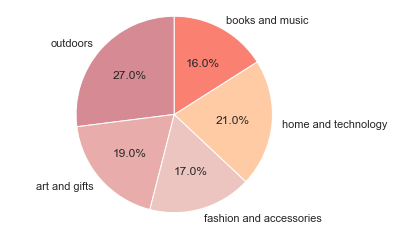

In [35]:
cat_distribution = rank.limit(100).groupBy(["category"]).agg(count(col("score_merchant")).alias("Number"))
cat = list(cat_distribution.select("category").distinct().toPandas()["category"])
num = list(cat_distribution.select("Number").distinct().toPandas()["Number"])

labels = cat
sizes = num
explode = (0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, 
        colors = ["#D58A94", "#E8ADAA", "#ECC5C0", "#FFCBA4", "#FA8072"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<font color='#98AFC7'><h3>The Information about top one merchant</h3></font> 


In [37]:
top = rank.first()["merchant_name"]
df_old = spark.read.parquet('../data/curated/merchant_consumer_abs')
df_info = spark.read.parquet('../data/meta/merchant_metadata.parquet')
df_predict = spark.read.parquet("../data/curated/predictions.parquet")
df_info.filter(col("merchant_name") == top)

merchant_name,revenue_level,avg(median_age),avg(sum(Undisclosed)),avg(sum(Female)),avg(sum(Male)),category,take_rate
Diam Eu Dolor LLC,b,45.283464315269356,17.95,78.15,77.85,outdoors,4.1


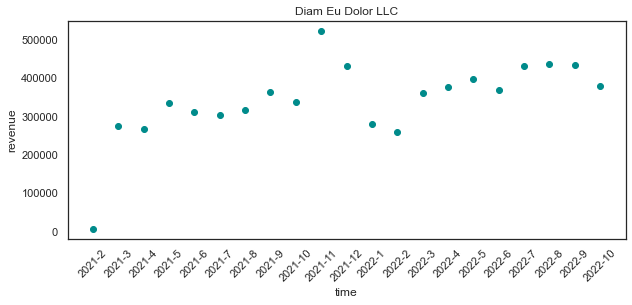

In [38]:
import numpy as np

revenue_monthly = df_old[df_old["merchant_name"] == top].groupBy(["merchant_name", "order_year", "order_month"]).agg(sum("dollar_value").alias("total_dollar_value"))
revenue_monthly = revenue_monthly.toPandas()
revenue_monthly = revenue_monthly.sort_values(["order_year", "order_month"])
revenue_monthly["period"] = revenue_monthly["order_year"].astype(str) + "-" + revenue_monthly["order_month"].astype(str)

x1 = revenue_monthly['period']
y1 = revenue_monthly['total_dollar_value']

plt.figure(figsize=(10,4))
plt.scatter(x1, y1, color="darkcyan")
plt.xticks(rotation=45)
plt.title(top)
plt.xlabel("time")
plt.ylabel("revenue")
plt.show()

The top one mechant statisfied our ranking criteria perfectly. The overall revenue for each month is around 300K, and the over all trend is increasing which means it has the potential to grow in the future, and the revenue are basically stable. 

<font color='#98AFC7'><h3>Ranking for each category</h3></font> 
For the revenue score, instead of ranking all the merchants together, we separated them by category and rank each one of them individually, this could obtain an overview of the performance for each category.

However, since our company may wants to work with the merchants from different category. THerefore, the top 100 among all of them will provide an idea of which merchant should be onboarded.

The results are shown as below.

In [43]:
outdoors = rank.filter(col("category") == "outdoors")
outdoors.sort(desc("score_category")).select("merchant_name", "category", "score_category").limit(10).show(truncate = False)

+------------------------------+--------+--------------+
|merchant_name                 |category|score_category|
+------------------------------+--------+--------------+
|Diam Eu Dolor LLC             |outdoors|1.0741723     |
|Ornare Limited                |outdoors|1.0171169     |
|Iaculis Aliquet Diam LLC      |outdoors|0.95743155    |
|Suspendisse Non Leo PC        |outdoors|0.9353053     |
|Auctor Company                |outdoors|0.9226278     |
|Lorem Ipsum Sodales Industries|outdoors|0.9001334     |
|Est Nunc Consulting           |outdoors|0.8961818     |
|Erat Vitae LLP                |outdoors|0.8725734     |
|Sit Amet PC                   |outdoors|0.82517       |
|Non Vestibulum Industries     |outdoors|0.8169963     |
+------------------------------+--------+--------------+



In [44]:
home = rank.filter(col("category") == "home and technology")
home.sort(desc("score_category")).limit(10).select("merchant_name", "category", "score_category").show(truncate = False)

+------------------------------+-------------------+--------------+
|merchant_name                 |category           |score_category|
+------------------------------+-------------------+--------------+
|Arcu Sed Eu Incorporated      |home and technology|0.93761206    |
|Interdum Feugiat Sed Inc.     |home and technology|0.92788863    |
|Mauris Non Institute          |home and technology|0.91884637    |
|Phasellus At Limited          |home and technology|0.9052398     |
|Phasellus Dapibus Incorporated|home and technology|0.89662254    |
|Neque Sed Dictum Incorporated |home and technology|0.8664858     |
|Nullam Enim Ltd               |home and technology|0.83385015    |
|Adipiscing Elit Foundation    |home and technology|0.8126714     |
|Libero Et Limited             |home and technology|0.80194247    |
|Sed Diam Foundation           |home and technology|0.78639317    |
+------------------------------+-------------------+--------------+



In [45]:
fashion = rank.filter(col("category") == "fashion and accessories")
fashion.sort(desc("score_category")).limit(10).select("merchant_name", "category", "score_category").show(truncate = False)

+-----------------------------+-----------------------+--------------+
|merchant_name                |category               |score_category|
+-----------------------------+-----------------------+--------------+
|Leo In Consulting            |fashion and accessories|0.9404063     |
|Nec Tellus Ltd               |fashion and accessories|0.9315626     |
|Dignissim Maecenas Foundation|fashion and accessories|0.90990543    |
|Gravida Mauris Incorporated  |fashion and accessories|0.8594937     |
|Dolor Quisque Inc.           |fashion and accessories|0.82576615    |
|Suspendisse Dui Corporation  |fashion and accessories|0.800493      |
|Iaculis LLC                  |fashion and accessories|0.7472295     |
|Blandit At LLC               |fashion and accessories|0.69433826    |
|Quam Elementum Corp.         |fashion and accessories|0.6943274     |
|Nulla Facilisis Institute    |fashion and accessories|0.6622891     |
+-----------------------------+-----------------------+--------------+



In [46]:
books = rank.filter(col("category") == "books and music")
books.sort(desc("score_category")).limit(10).select("merchant_name", "category", "score_category").show(truncate = False)

+-------------------------+---------------+--------------+
|merchant_name            |category       |score_category|
+-------------------------+---------------+--------------+
|Lobortis Ultrices Company|books and music|0.90350425    |
|Placerat Orci Institute  |books and music|0.8635449     |
|Tempor Est Foundation    |books and music|0.8298706     |
|Euismod In Corp.         |books and music|0.811496      |
|Ornare Fusce Inc.        |books and music|0.79602474    |
|Pretium Et LLC           |books and music|0.7922876     |
|Nullam Consulting        |books and music|0.7884643     |
|Suspendisse Ac Associates|books and music|0.7807266     |
|Dignissim Lacus PC       |books and music|0.7583365     |
|Sodales At LLC           |books and music|0.74479544    |
+-------------------------+---------------+--------------+



In [47]:
art = rank.filter(col("category") == "art and gifts")
art.sort(desc("score_category")).limit(10).select("merchant_name", "category", "score_category").show(truncate = False)

+-----------------------------+-------------+--------------+
|merchant_name                |category     |score_category|
+-----------------------------+-------------+--------------+
|Arcu Morbi Institute         |art and gifts|1.0193049     |
|Dictum Phasellus In Institute|art and gifts|0.9309275     |
|Magna Malesuada Corp.        |art and gifts|0.91031474    |
|Aliquam Auctor Associates    |art and gifts|0.90847194    |
|Phasellus At Company         |art and gifts|0.90735465    |
|Orci In Consequat Corporation|art and gifts|0.89625275    |
|Ultricies Dignissim LLP      |art and gifts|0.87261033    |
|Lacus Consulting             |art and gifts|0.8620796     |
|Odio Phasellus Institute     |art and gifts|0.7798315     |
|Nulla Vulputate Company      |art and gifts|0.77485263    |
+-----------------------------+-------------+--------------+



The outdoors category has relatively higher score than the other groups, and it is also the majority class in the top 100 mechants. Therefore, if there is a merchants with little information, we can check if their category is outdoors or not and treat it as an extra points. 

Moreover, we can compare it against existing merchants of similar category and revenue band. We can also use demographics of its customers, if provided, to predict its future revenue through our model.